In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from video import *
import numpy as np
import ultralytics
import cv2 as cv
from utils import *
from tqdm import tqdm 
from ultralytics import RTDETR
from multiprocessing import Pool

In [3]:
fundamental_matrices = {
    "A" : {
        "B": np.load("fundamental_matrices/AB.npy"),
        "C": np.load("fundamental_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("fundamental_matrices/BA.npy"),
        "C": np.load("fundamental_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("fundamental_matrices/CB.npy"),
        "A": np.load("fundamental_matrices/CA.npy"),
    }
}

In [4]:
homography_matrices = {
    "A" : {
        "B": np.load("homography_matrices/AB.npy"),
        "C": np.load("homography_matrices/AC.npy"),
    },
    "B": {
        "A": np.load("homography_matrices/BA.npy"),
        "C": np.load("homography_matrices/BC.npy"),
    },
    "C": {
        "B": np.load("homography_matrices/CB.npy"),
        "A": np.load("homography_matrices/CA.npy"),
    }
}

In [5]:
video = "09"

In [6]:
if 'query' in globals():
    del query
if 'reference' in globals():
    del reference

a = load_video(f"train/task2/{video}_1.mp4")
b = load_video(f"train/task2/{video}_2.mp4")
print(a.num_frames())
print(b.num_frames())

508
533


In [7]:
def read_box(path):
    with open(path, "r") as f:
        lines = f.readlines()
    _, box = lines

    box = box.strip()
    _index, x1, y1, x2, y2 = list(map(int , box.split(" ")))
    return (x1, y1, x2, y2)

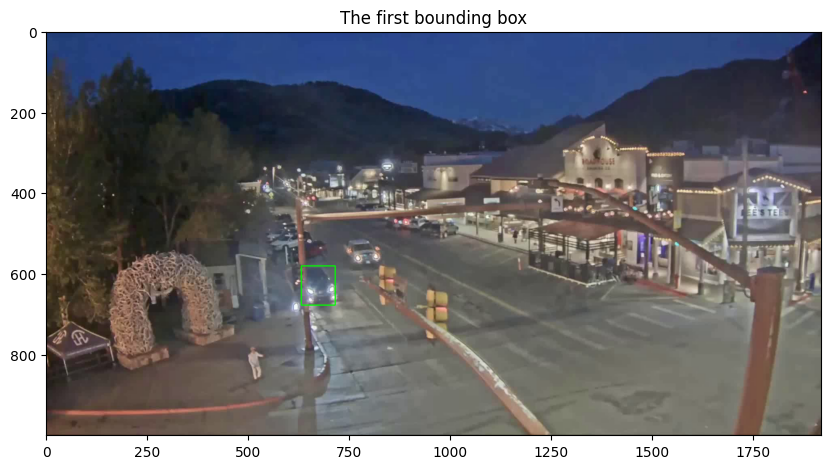

In [8]:
initial_bbox = read_box(f"train/task2/{video}_1.txt")
plot = a.get_frame(0).raw().copy()
cv.rectangle(plot, initial_bbox[:2], initial_bbox[2:], (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.title("The first bounding box")
plt.imshow(plot)

In [10]:
a.do_tracking(visualize=True)
b.do_tracking(visualize=True)


WARNING ⚠️ imgsz=[1000, 1920] must be multiple of max stride 32, updating to [1024, 1920]
0: 1024x1920 6 cars, 89.9ms
Speed: 4.7ms preprocess, 89.9ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 1920)

WARNING ⚠️ imgsz=[1000, 1920] must be multiple of max stride 32, updating to [1024, 1920]
0: 1024x1920 5 cars, 86.3ms
Speed: 5.5ms preprocess, 86.3ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1920)

WARNING ⚠️ imgsz=[1000, 1920] must be multiple of max stride 32, updating to [1024, 1920]
0: 1024x1920 6 cars, 1 truck, 84.8ms
Speed: 5.4ms preprocess, 84.8ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 1920)

WARNING ⚠️ imgsz=[1000, 1920] must be multiple of max stride 32, updating to [1024, 1920]
0: 1024x1920 5 cars, 86.7ms
Speed: 4.7ms preprocess, 86.7ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1920)

WARNING ⚠️ imgsz=[1000, 1920] must be multiple of max stride 32, updating to [1024, 1920]
0: 1024x1920 3 cars, 2 truck

In [15]:
def find_best_intersection(objects, bounding_box, threshold=0.5):
    max_iou = 0
    best = None

    for object in objects:
        bb = object["bbox"] 

        iou = bb_intersection_over_union(bb, bounding_box)
        if iou > threshold and iou > max_iou:
            best = object
            max_iou = iou

    return best 

In [13]:
def find_closest_object(objects, position, threshold=100):
    min_distance = np.inf
    best = None

    for object in objects:
        bb = object["bbox"]
        center= bounding_box_center(bb) 
        distance = np.linalg.norm(np.array(center) - np.array(position))

        if distance< threshold and distance < min_distance:
            best = object
            min_distance = distance
    return best

In [16]:
kalman = cv.KalmanFilter(4, 2)
kalman.measurementMatrix = np.array(
            [[1, 0, 0, 0],
             [0, 1, 0, 0],
             ], np.float32)
kalman.transitionMatrix = np.array(
            [[1, 0, 1, 0],
             [0, 1, 0, 1],
             [0, 0, 1, 0],
             [0, 0, 0, 1]], np.float32)

kalman.processNoiseCov = np.array(
            [[1, 0, 0, 0],
             [0, 1, 0, 0],
             [0, 0, 1, 0],
             [0, 0, 0, 1]], np.float32) * 0.01

kalman.measurementNoiseCov = np.array(
            [[1, 0],
             [0, 1]], np.float32) * 150 

initial_center = bounding_box_center(initial_bbox)

kalman.statePre = np.array([[initial_center[0]], 
                            [initial_center[1]], 
                            [0],
                            [0]], np.float32)
kalman.statePost = np.array([[initial_center[0]],
                            [initial_center[1]], 
                            [0],
                            [0]], np.float32)
last_bbox = initial_bbox

for frame_index in range(0, a.num_frames()):
    frame = a.get_frame(frame_index)
    objects = frame.objects()

    prediction = kalman.predict()[:2].flatten().astype(np.int32)
    closest = find_closest_object(objects, prediction, threshold=50)

    if closest is not None:
        correction = closest["bbox"]
        center = bounding_box_center(correction)

        kalman.correct(np.array([
                                [center[0]], 
                                [center[1]]
                                ], np.float32))

        last_bbox = closest["bbox"]

    plot = frame.raw().copy()
    cv.circle(plot, (prediction[0], prediction[1]), 5, (255, 0, 0), -1)
    cv.rectangle(plot, last_bbox[:2], last_bbox[2:], (0, 255, 0), 2)
    cv.imshow("tracking", plot)
    cv.waitKey(100)

cv.destroyAllWindows()